
# PyTorch Version of the TensorFlow Notebook

This notebook replicates the exact functionality of the original TensorFlow-based notebook using PyTorch. It includes:
- Data loading and preprocessing (from images and CSV files)
- Building and training a CNN model for classification
- Model evaluation and predictions
- Saving model weights


In [1]:

import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
print(torch.cuda.is_available())

True


In [3]:

# Function to load and preprocess images and labels
def load_data(image_folder, label_file, target_size=(160, 120)):
    labels_df = pd.read_csv(label_file)
    images = []
    labels = []

    # Create a dictionary to map letters to numerical labels
    unique_letters = labels_df['label'].unique()  # Get unique letters from the 'label' column
    letter_to_label_dict = {letter: i for i, letter in enumerate(unique_letters)}

    for index, row in labels_df.iterrows():
        img_path = os.path.join(image_folder, row['image'])  # Use 'image' column
        img = Image.open(img_path).convert("L")
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0
        images.append(img_array)

        # Convert letter label to numerical label using the dictionary
        labels.append(letter_to_label_dict[row['label']])

    return np.array(images), np.array(labels), letter_to_label_dict  # Return the dictionary

# Load the dataset
image_folder = "./"
label_file = "./data/labels.csv"  # Updated label file name
X, y, letter_to_label_dict = load_data(image_folder, label_file)  # Get the dictionary from the function call

# Create the label to letter dictionary
label_to_letter_dict = {i: letter for letter, i in letter_to_label_dict.items()}


In [4]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [5]:

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = ImageDataset(X_train, y_train)
test_dataset = ImageDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
# Model Definition
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.4)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.5)
        
        # Placeholder for dynamically calculating the flattened size
        self.flatten = nn.Flatten()
        self.fc1 = None  # Define fully connected later
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = None  # Define last FC layer later
        
        # Activation
        self.relu = nn.ReLU()

        # Create placeholders for dynamic calculation of features
        self.num_classes = num_classes

    def initialize_fc_layers(self, input_shape):
        # Pass a dummy tensor through the conv layers to compute the flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            x = self.pool1(self.bn1(self.conv1(dummy_input)))
            x = self.pool2(self.conv2(x))
            x = self.pool3(self.conv3(x))
            flattened_size = x.numel()  # Total elements after flattening

        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, self.num_classes)

    def forward(self, x):
        x = self.pool1(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        
        x = self.pool2(self.conv2(x))
        x = self.dropout2(x)
        
        x = self.pool3(self.conv3(x))
        x = self.dropout3(x)
        
        x = self.flatten(x)
        x = self.dropout4(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [7]:
# Enhanced CNN
class EnhancedCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNNModel, self).__init__()

        self.num_classes = num_classes

        # Convolutional blocks
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output: 32x320x240
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 32x160x120

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64x160x120
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x80x60

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: 128x80x60
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 128x40x30

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Output: 256x40x30
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 256x20x15

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Output: 512x20x15
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 512x10x7

        # Fully connected layers are initialized dynamically
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def initialize_fc_layers(self, input_shape):
        """Initialize the fully connected layers dynamically based on the input shape."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            x = self.pool1(self.bn1(self.conv1(dummy_input)))
            x = self.pool2(self.conv2(x))
            x = self.pool3(self.conv3(x))
            x = self.pool4(self.conv4(x))
            x = self.pool5(self.conv5(x))
            flattened_size = x.numel()  # Total elements after flattening

        # Dynamically initialize fully connected layers
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, self.num_classes)

        # Print the initialized sizes for debugging
        print(f"Initialized fc1 with input size {flattened_size} and output size 512")
        print(f"Initialized fc2 with input size 512 and output size 256")
        print(f"Initialized fc3 with input size 256 and output size {self.num_classes}")

    def forward(self, x):
        # Convolutional blocks
        x = self.pool1(self.bn1(self.conv1(x)))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))
        x = self.pool5(self.conv5(x))

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [8]:
# Intantiate the model
input_shape = (1, 120, 160)  # Grayscale image: 1 channel, 60x80 dimensions
model = EnhancedCNNModel(num_classes=len(np.unique(y)))
model.initialize_fc_layers(input_shape)

Initialized fc1 with input size 7680 and output size 512
Initialized fc2 with input size 512 and output size 256
Initialized fc3 with input size 256 and output size 62


In [9]:
# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 75  # Match TensorFlow's training epochs
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/75, Loss: 4.1535
Epoch 2/75, Loss: 4.0822
Epoch 3/75, Loss: 3.7087
Epoch 4/75, Loss: 3.3595
Epoch 5/75, Loss: 2.8807
Epoch 6/75, Loss: 2.4479
Epoch 7/75, Loss: 2.1299
Epoch 8/75, Loss: 1.8843
Epoch 9/75, Loss: 1.5910
Epoch 10/75, Loss: 1.3587
Epoch 11/75, Loss: 1.2736
Epoch 12/75, Loss: 1.1922
Epoch 13/75, Loss: 0.9972
Epoch 14/75, Loss: 0.9799
Epoch 15/75, Loss: 1.0756
Epoch 16/75, Loss: 1.1786
Epoch 17/75, Loss: 1.0870
Epoch 18/75, Loss: 0.8345
Epoch 19/75, Loss: 0.7961
Epoch 20/75, Loss: 0.8432
Epoch 21/75, Loss: 0.6934
Epoch 22/75, Loss: 0.6745
Epoch 23/75, Loss: 0.7112
Epoch 24/75, Loss: 0.6482
Epoch 25/75, Loss: 0.7035
Epoch 26/75, Loss: 0.6453
Epoch 27/75, Loss: 0.6604
Epoch 28/75, Loss: 0.6901
Epoch 29/75, Loss: 0.6366
Epoch 30/75, Loss: 0.6586
Epoch 31/75, Loss: 0.5149
Epoch 32/75, Loss: 0.4948
Epoch 33/75, Loss: 0.4884
Epoch 34/75, Loss: 0.4627
Epoch 35/75, Loss: 0.4333
Epoch 36/75, Loss: 0.3543
Epoch 37/75, Loss: 0.4425
Epoch 38/75, Loss: 0.3556
Epoch 39/75, Loss: 0.

In [15]:

# Evaluate the model
model.eval()
all_preds = []
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to the same device as the model
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.77


In [11]:

# # Save the model weights
# torch.save(model.state_dict(), './weights/cnn_weights.pth')


In [12]:
from sklearn.metrics import confusion_matrix

# Generate predictions and compute the confusion matrix
y_true = []  # Collect true labels
y_pred = []  # Collect predicted labels

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to the same device as the model
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())  # Move to CPU before converting to numpy
        y_pred.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy

# Convert numerical labels back to letters
y_true_letters = [label_to_letter_dict[label] for label in y_true]
y_pred_letters = [label_to_letter_dict[label] for label in y_pred]

# Unique letters (characters)
unique_letters = list(label_to_letter_dict.values())

# Compute confusion matrix
cm = confusion_matrix(y_true_letters, y_pred_letters, labels=unique_letters)

# Calculate accuracy per character
accuracy_per_char = np.diag(cm) / np.sum(cm, axis=1)
char_accuracy_dict = dict(zip(unique_letters, accuracy_per_char))

# Sort characters by accuracy in descending order
sorted_char_accuracy = sorted(char_accuracy_dict.items(), key=lambda item: item[1], reverse=True)

# Get the best and worst 3 characters
best_3_chars = sorted_char_accuracy[:3]
worst_3_chars = sorted_char_accuracy[-3:]

# Print the results
print("Best 3 Characters:")
for char, accuracy in best_3_chars:
    print(f"{char}: {accuracy:.2f}")

print("\nWorst 3 Characters:")
for char, accuracy in worst_3_chars:
    print(f"{char}: {accuracy:.2f}")


Best 3 Characters:
D: 1.00
H: 1.00
L: 1.00

Worst 3 Characters:
x: 0.46
y: 0.46
O: 0.38


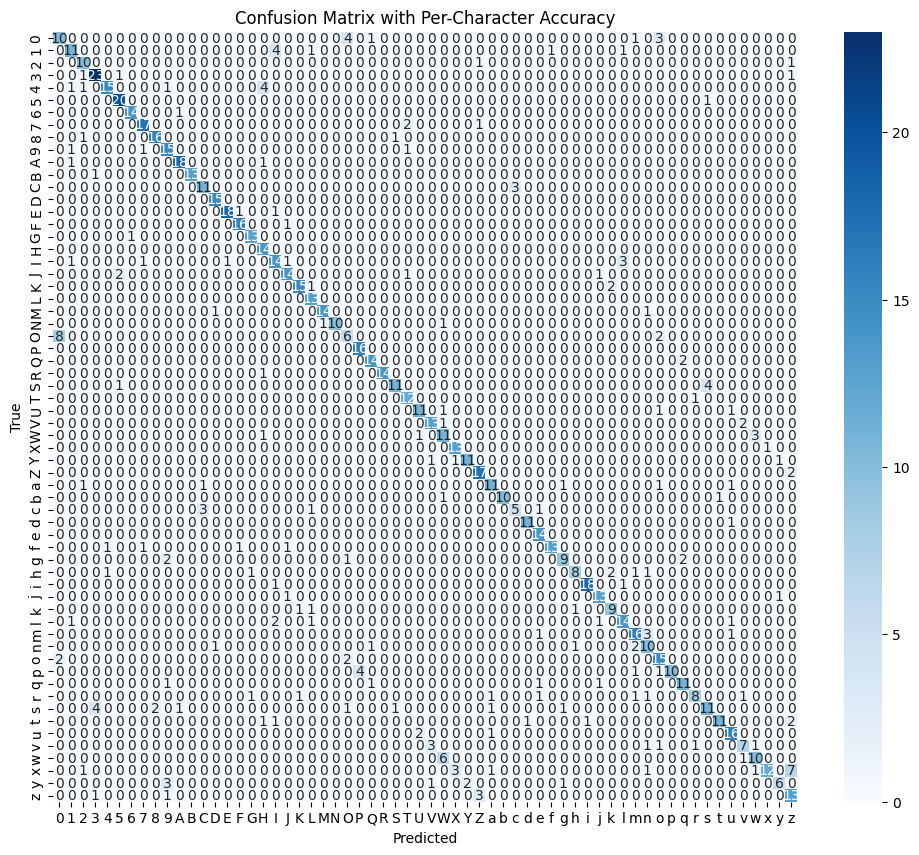

In [13]:
# Heatmap
# Plot heatmap for confusion matrix
plt.figure(figsize=(12, 10))  # Adjust the size if needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_letters, yticklabels=unique_letters)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Per-Character Accuracy')
plt.show()


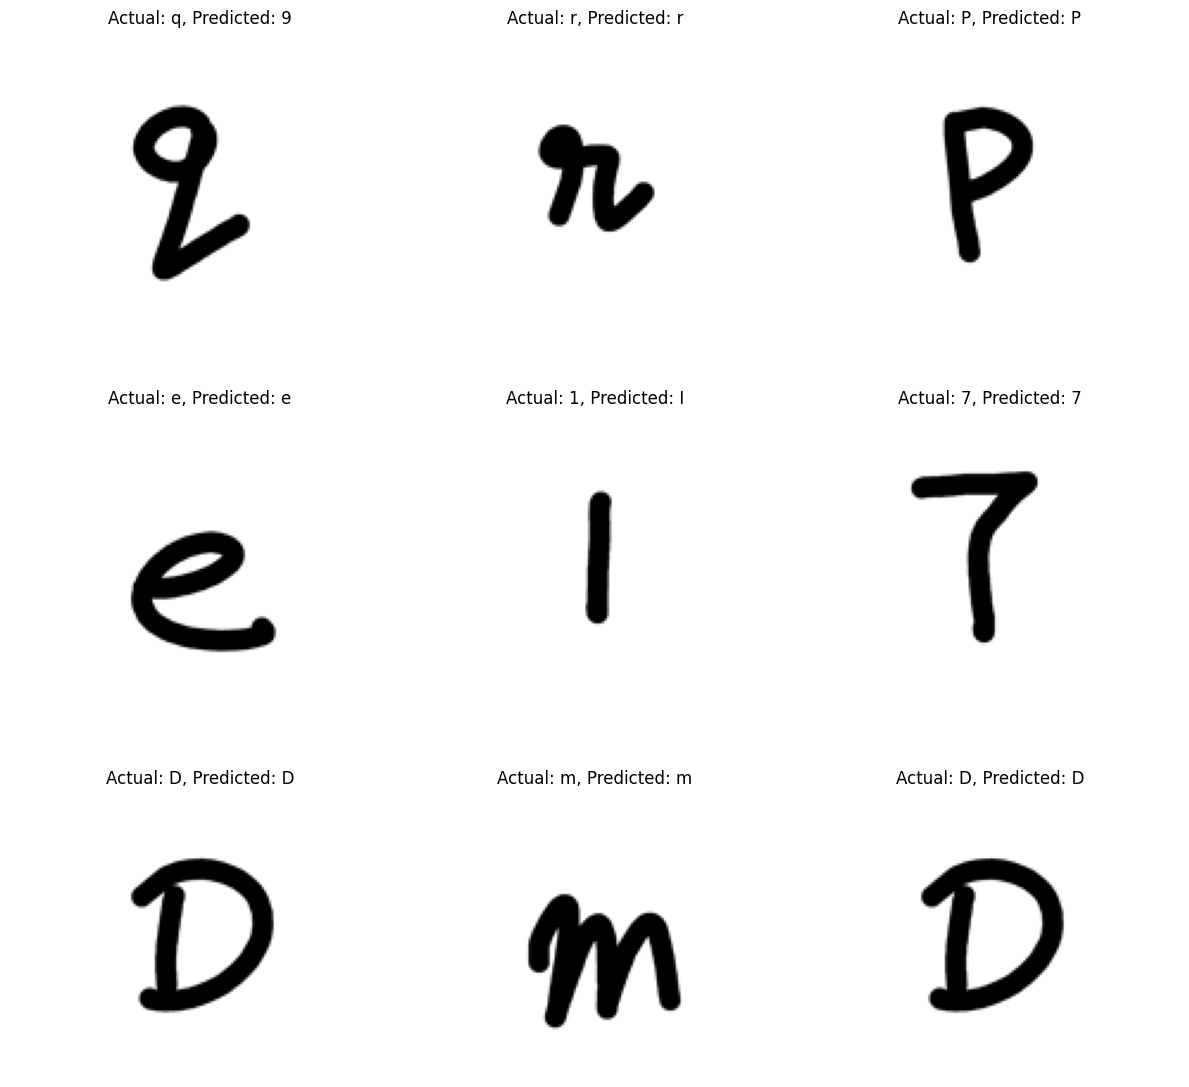

In [14]:
# Images and Predictions
# Visualize some test images with their predictions
import random

# Get a batch of test data
data_iter = iter(test_loader)
X_batch, y_batch = next(data_iter)

# Run the model on the batch
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to the same device as the model
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())  # Move to CPU before converting to numpy
        y_pred.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy

# Display a few images with their predicted and actual labels
plt.figure(figsize=(12, 12))
for i in range(9):  # Display 9 images
    idx = random.randint(0, len(X_batch) - 1)  # Pick a random index from the batch
    image = X_batch[idx].cpu().squeeze().numpy()  # Move to CPU, get the image and remove channel dimension
    actual_label = label_to_letter_dict[y_batch[idx].cpu().item()]
    predicted_label = label_to_letter_dict[preds[idx].cpu().item()]

    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()
